# Práctica 4
El conjunto de datos contiene 14 atributos, cuya descripción es la siguiente:

    FL_DATE: Fecha del vuelo
    OP_CARRIER: Identificador de la aerolínea
    OP_CARRIER_FL_NUM: Número de vuelo
    ORIGIN: Código del aeropuerto de origen
    DEST: Código del aeropuerto de destino
    CRS_DEP_TIME: Hora planeada de salida
    DEP_TIME: Hora actual de salida
    DEP_DELAY: Retraso en la salida en minutos
    TAXI_OUT: El tiempo transcurrido entre la salida desde el aeropuerto de origen y el atributo "WHEELS_OFF"
    WHEELS_OFF: Hora a la que las llantas del avión dejaron de tocar el suelo
    CRS_ARR_TIME: Hora planeada de llegada
    ARR_DELAY: Retraso total en la llegada en minutos (atributo a predecir)
    CRS_ELAPSED_TIME: Tiempo total planeado del vuelo
    DISTANCE: Distancia entre los dos aeropuertos


La tarea a realizar es predecir con anticipación si un vuelo se va a retrasar, llegará antes o llegará a tiempo (pocos momentos después de que despegue), por lo que el atributo a predecir es "ARR_DELAY". Sin embargo, como esta variable está en minutos, se deberá realizar un preprocesamiento de los datos para transformarla en las siguientes clases:

    Early: Cuando el avión llega más de
    15 minutos antes de la hora planeada de llegada.
    Delay: Cuando el avión llega más de
    15 minutos después de la hora planeada de llegada.
    On time: Cuando el avión llega ±15
    minutos de la hora planeada de llegada.


La métrica que se utilizará para decidir las posiciones será el F1-score macro.

# Resumen

Se realizó un procesamiento de los datos de acuerdo a las tres clases: early, delay y on time. Posteriormente, las variables que estaban en formato de horas fueron preprocesadas para que estuvieran en minutos, partiendo de las 12:00.

Asimismo, se eliminaron los valores extremos, los valores perdidos y los NAs. A su vez, se construyeron variables adicionales al conjunto de datos, tales como DEPTIME-CRSDEPTIME, KMH y DUMMY_DELAY.

Se aplicó el método de Lasso regularizado para la selección de características y se utilizó regresión logística, obteniéndose un F-score macro de 0.70.

Continuando con el análisis, se realizó una reducción de dimensionalidad con componentes principales, seleccionando los tres primeros componentes que conservaban el 98% de la varianza acumulada.

Por último, se consideraron únicamente los tres primeros componentes principales para realizar la clasificación de los datos, con el objetivo de mantener la eficiencia computacional.

Se aplicaron los modelos de regresión logística, Gradient Boosting y KNN. Se planeaba ejecutar siete algoritmos de clasificación adicionales; sin embargo, no fue posible debido al alto costo computacional.

Finalmente, se seleccionó el modelo de KNN con 10 vecinos como el mejor modelo encontrado, alcanzando un F-score macro de 0.72, redondeado a dos decimales.

Posteriormente, se realizaron las predicciones para un conjunto de datos de prueba con clases desconocidas, y se elaboró un gráfico de la predicción de las clases. Es posible identificar que, si la extracción de ese conjunto de datos de prueba del conjunto original fue aleatoria, por la ley de los grandes números, el modelo entrenado está sesgado hacia la clase early. Esto se debe a que en el análisis exploratorio se identificó que las clases early y late tienen un porcentaje similar.

### ***Limpieza de datos***


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos
df = pd.read_csv('drive/MyDrive/train_airlines_delay_challenge.csv')

# Mostrar las primeras filas del dataset
df.head()

# Información general sobre el dataset
df.info()

# Descripción estadística del dataset
df.describe()

# Revisión de valores nulos
print(df.isnull().sum())

# Limpieza de datos

# Eliminar filas con valores nulos (si es necesario)
df_clean = df.dropna()

# Convertir la columna 'FL_DATE' en tipo datetime
df_clean['FL_DATE'] = pd.to_datetime(df_clean['FL_DATE'])

# Convertir tiempos de CRS_DEP_TIME y DEP_TIME en formato correcto (HHMM a datetime)
#df_clean['CRS_DEP_TIME'] = pd.to_datetime(df_clean['CRS_DEP_TIME'], format='%H%M', errors='coerce').dt.time
#df_clean['DEP_TIME'] = pd.to_datetime(df_clean['DEP_TIME'], format='%H%M', errors='coerce').dt.time
#df_clean['CRS_ARR_TIME'] = pd.to_datetime(df_clean['CRS_ARR_TIME'], format='%H%M', errors='coerce').dt.time

# Remover las filas donde CRS_DEP_TIME o DEP_TIME no pudieron convertirse correctamente
#df_clean = df_clean.dropna(subset=['CRS_DEP_TIME', 'DEP_TIME'])

# Revisión del tipo de datos después de la conversión
df_clean.info()

#

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000000 entries, 0 to 8999999
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FL_DATE            object 
 1   OP_CARRIER         object 
 2   OP_CARRIER_FL_NUM  int64  
 3   ORIGIN             object 
 4   DEST               object 
 5   CRS_DEP_TIME       float64
 6   DEP_TIME           float64
 7   DEP_DELAY          float64
 8   TAXI_OUT           float64
 9   WHEELS_OFF         float64
 10  CRS_ARR_TIME       float64
 11  ARR_DELAY          float64
 12  CRS_ELAPSED_TIME   float64
 13  DISTANCE           float64
dtypes: float64(9), int64(1), object(4)
memory usage: 961.3+ MB
FL_DATE              0
OP_CARRIER           0
OP_CARRIER_FL_NUM    0
ORIGIN               0
DEST                 0
CRS_DEP_TIME         0
DEP_TIME             0
DEP_DELAY            0
TAXI_OUT             0
WHEELS_OFF           0
CRS_ARR_TIME         0
ARR_DELAY            0
CRS_ELAPSED_TIME     0
DISTANCE    

In [3]:
df

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE
0,2009-09-05,AA,2062,MIA,BOS,1055.0,1139.0,44.0,15.0,1154.0,1405.0,30.0,190.0,1258.0
1,2009-05-08,XE,2926,IAH,ELP,2115.0,2112.0,-3.0,17.0,2129.0,2219.0,-15.0,124.0,667.0
2,2009-03-16,OH,6433,CVG,DSM,1430.0,1425.0,-5.0,25.0,1450.0,1518.0,7.0,108.0,505.0
3,2009-03-04,OO,5439,LAX,SBA,820.0,814.0,-6.0,15.0,829.0,905.0,-11.0,45.0,89.0
4,2009-06-12,WN,615,LAS,MCI,1235.0,1234.0,-1.0,13.0,1247.0,1735.0,-26.0,180.0,1140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8999995,2017-10-27,WN,4233,PDX,SMF,2025.0,2022.0,-3.0,11.0,2033.0,2150.0,-6.0,85.0,479.0
8999996,2017-01-06,OO,4482,SEA,SMF,2105.0,2113.0,8.0,23.0,2136.0,2306.0,7.0,121.0,605.0
8999997,2017-09-24,WN,3997,DEN,SNA,1400.0,1436.0,36.0,11.0,1447.0,1520.0,33.0,140.0,846.0
8999998,2017-07-28,AS,829,SAN,OGG,720.0,720.0,0.0,10.0,730.0,1016.0,-13.0,356.0,2541.0


### **Análisis exploratorio de los datos**

En el primer gráfico se identifica la distribución del retraso en las llegadas de los aviones, y se observa que la mayoría está en un rango menor a 250 minutos.

Debido a lo anterior, se realiza una selección de los datos considerando los cuartiles 1 y 4 de la distribución.

Posteriormente, identificamos que existe una alta varianza entre los diferentes destinos de los vuelos.

A su vez, se identifica que los vuelos que recorren menos distancia son los que presentan mayor frecuencia en los retrasos.

Por otro lado, es posible deducir que hay una relación entre el retraso en la salida y el retraso en la llegada de los vuelos.

Asimismo, identificamos que los retrasos en los vuelos presentan una distribución normal que está centrada en los valores negativos, lo que indicaría que, en promedio, los vuelos llegan tarde.

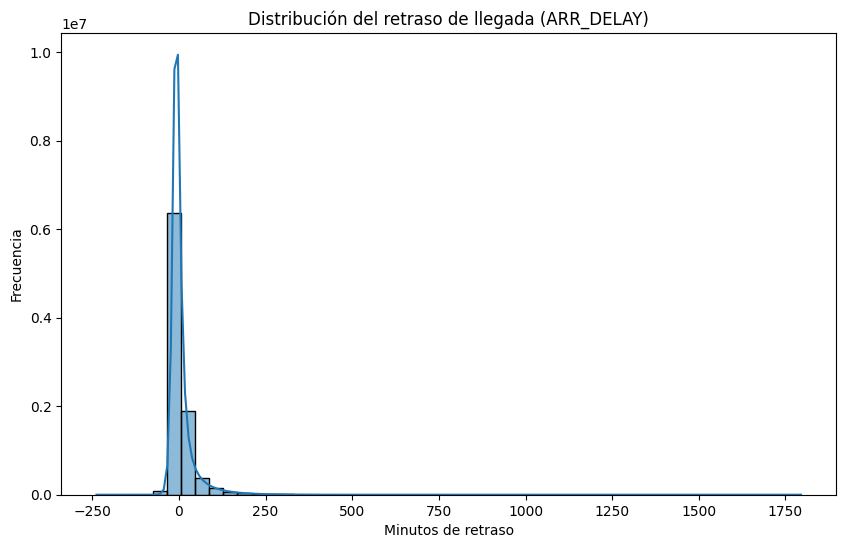

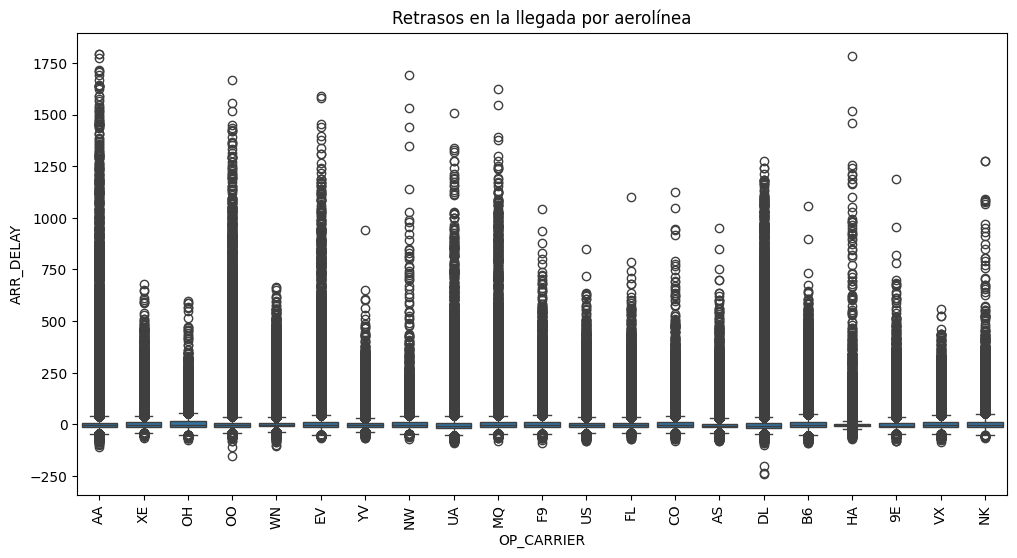

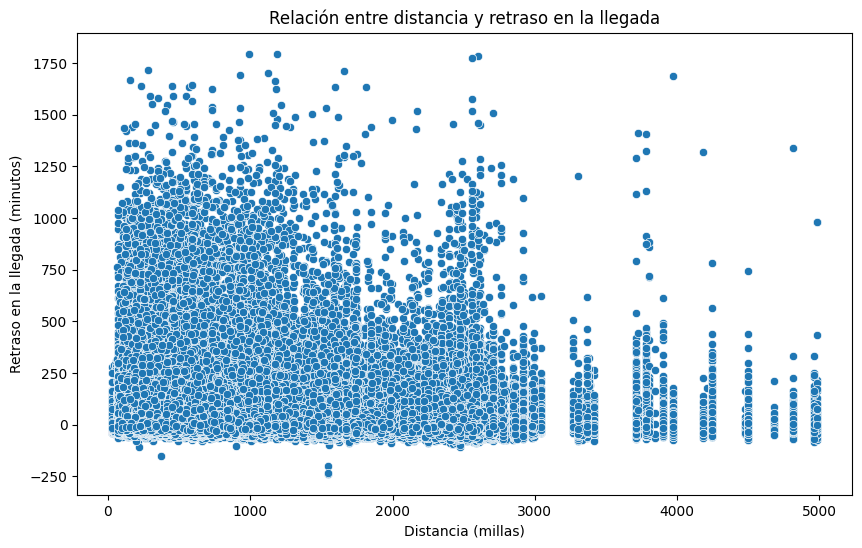

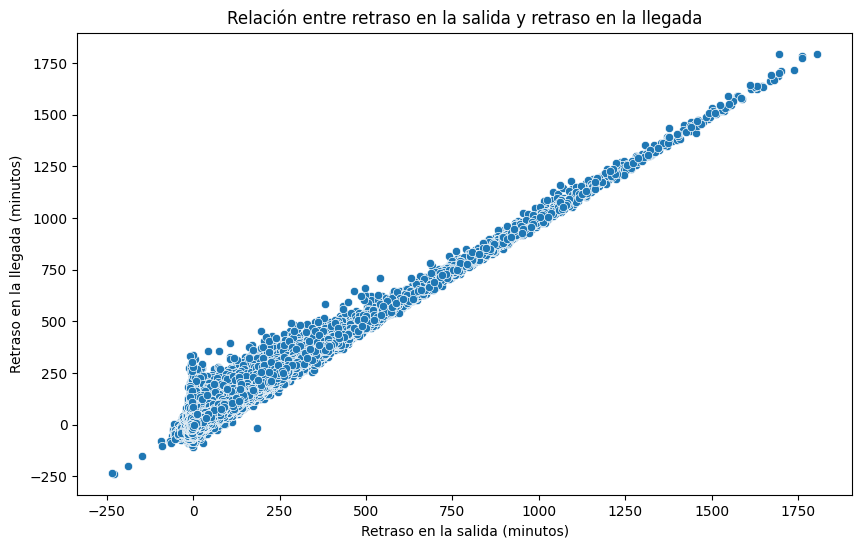

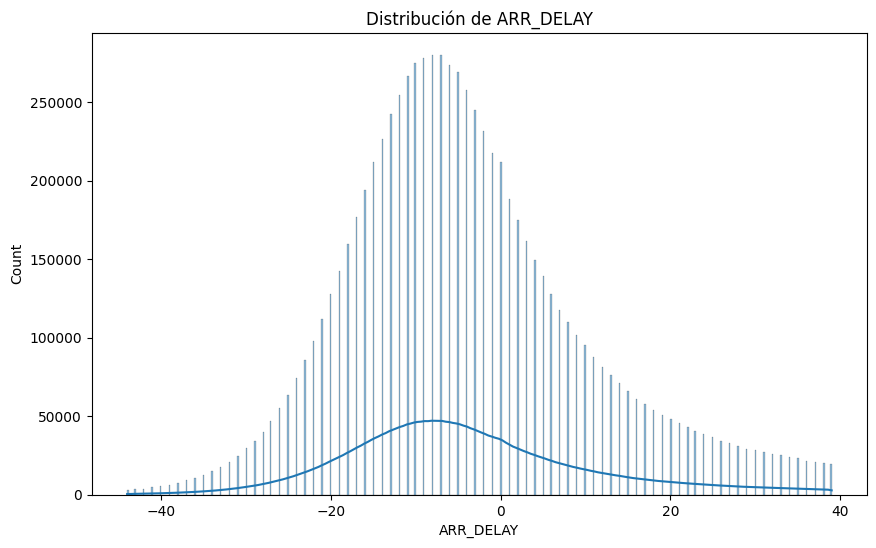

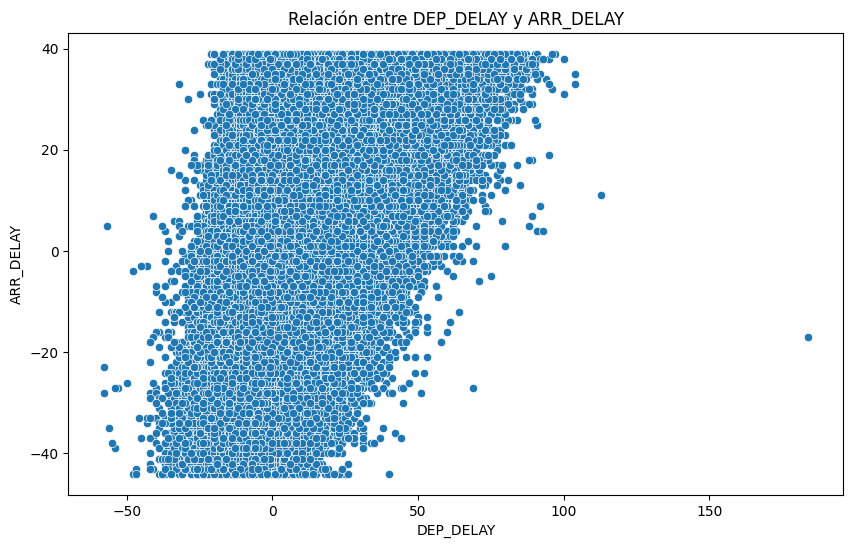

In [3]:
 #Análisis exploratorio de datos (EDA)

# Distribución de ARR_DELAY (el objetivo a predecir)
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['ARR_DELAY'], bins=50, kde=True)
plt.title('Distribución del retraso de llegada (ARR_DELAY)')
plt.xlabel('Minutos de retraso')
plt.ylabel('Frecuencia')
plt.show()

# Correlación entre las variables numéricas
#plt.figure(figsize=(10, 6))
#sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm', fmt='.2f')
#plt.title('Matriz de correlación')
#plt.show()

# Retrasos por aerolínea
plt.figure(figsize=(12, 6))
sns.boxplot(x='OP_CARRIER', y='ARR_DELAY', data=df_clean)
plt.title('Retrasos en la llegada por aerolínea')
plt.xticks(rotation=90)
plt.show()

# Retrasos por aeropuerto de origen
#plt.figure(figsize=(12, 6))
#sns.boxplot(x='ORIGIN', y='ARR_DELAY', data=df_clean)
#plt.title('Retrasos en la llegada por aeropuerto de origen')
#plt.xticks(rotation=90)
#plt.show()

# Relación entre la distancia y el retraso de llegada
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DISTANCE', y='ARR_DELAY', data=df_clean)
plt.title('Relación entre distancia y retraso en la llegada')
plt.xlabel('Distancia (millas)')
plt.ylabel('Retraso en la llegada (minutos)')
plt.show()

# Relación entre retraso en la salida y retraso en la llegada
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DEP_DELAY', y='ARR_DELAY', data=df_clean)
plt.title('Relación entre retraso en la salida y retraso en la llegada')
plt.xlabel('Retraso en la salida (minutos)')
plt.ylabel('Retraso en la llegada (minutos)')
plt.show()

#--------------------------------------------------------

# Eliminar o corregir outliers (ejemplo en ARR_DELAY)
q1 = df['ARR_DELAY'].quantile(0.25)
q3 = df['ARR_DELAY'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
df = df[(df['ARR_DELAY'] >= lower_bound) & (df['ARR_DELAY'] <= upper_bound)]


# Visualización de las distribuciones
plt.figure(figsize=(10, 6))
sns.histplot(df['ARR_DELAY'], kde=True)
plt.title('Distribución de ARR_DELAY')
plt.show()

# Relaciones entre variables
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['DEP_DELAY'], y=df['ARR_DELAY'])
plt.title('Relación entre DEP_DELAY y ARR_DELAY')
plt.show()



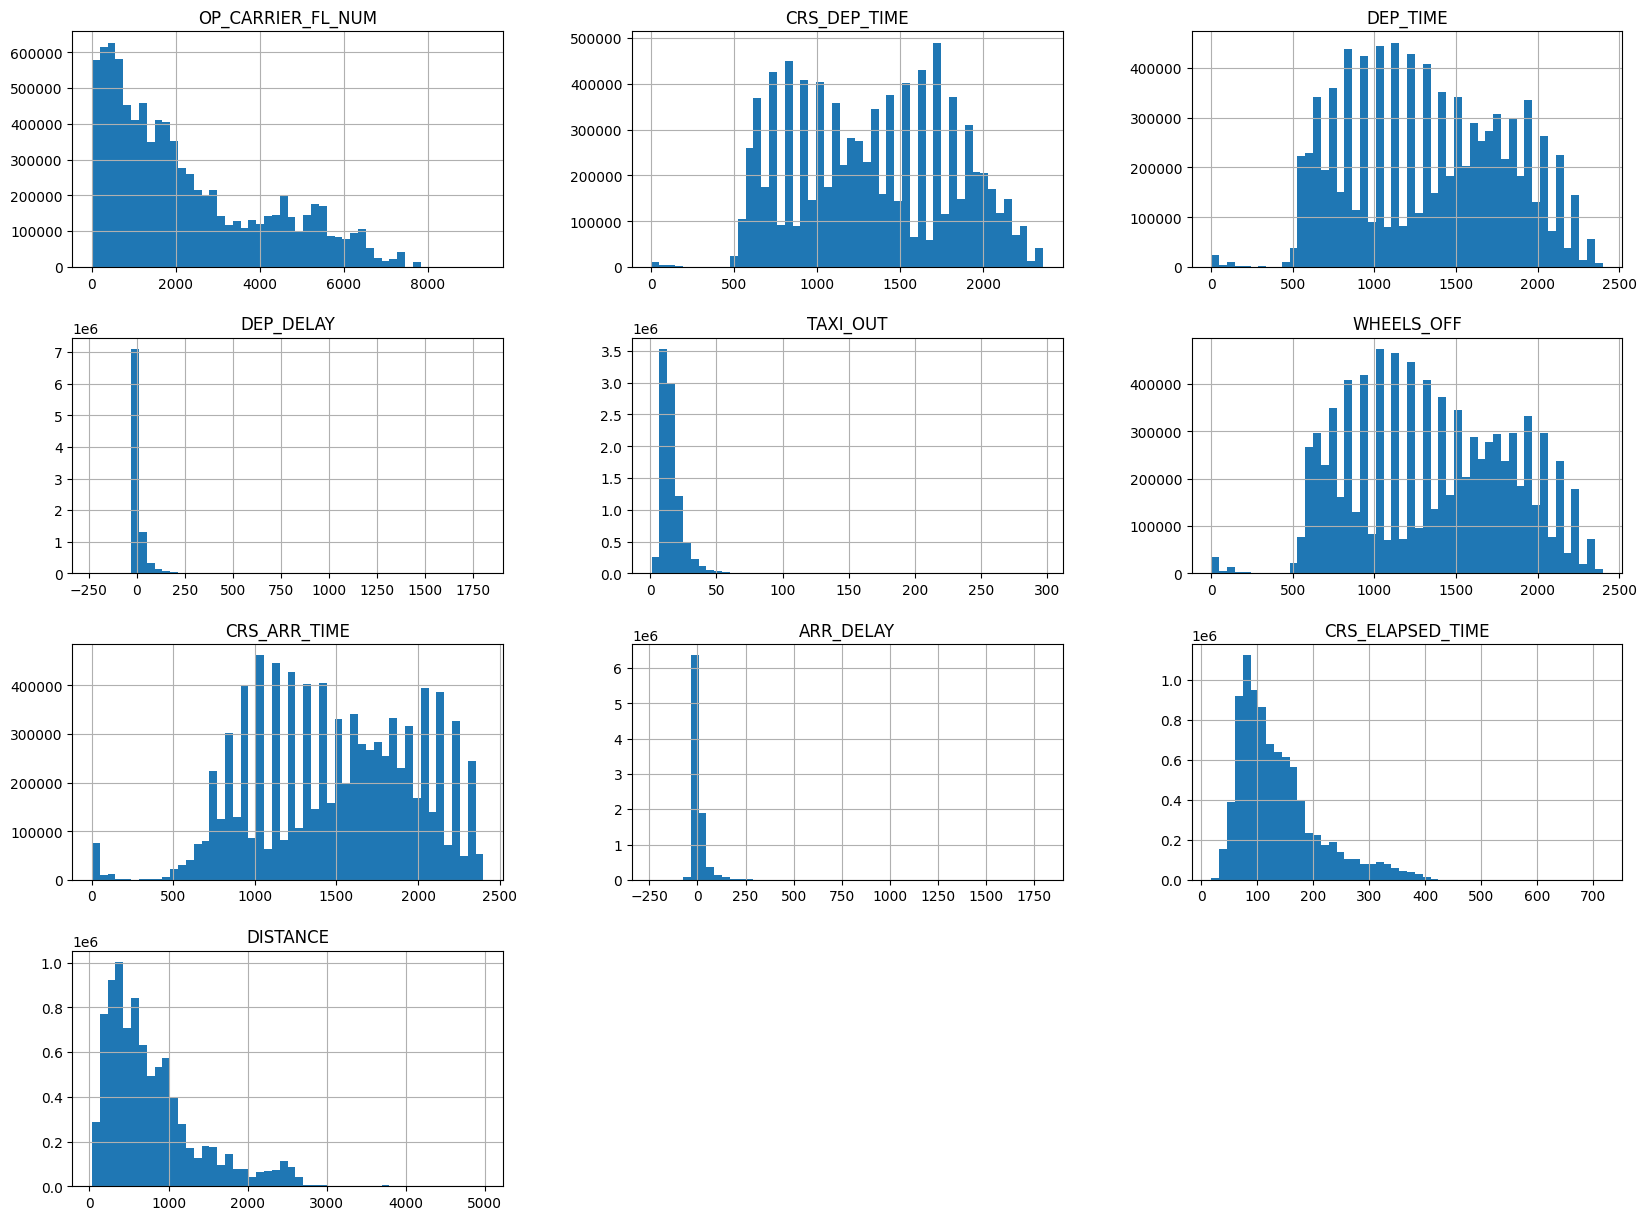

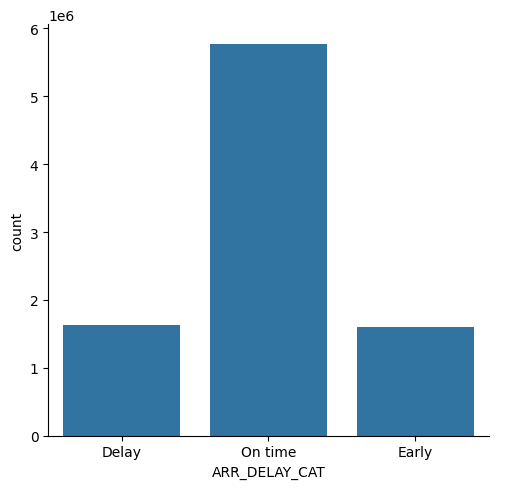

In [4]:

df.hist(bins=50, figsize=(20,15))
plt.show()

df.head()

# Transformar la variable ARR_DELAY en categorías
def categorize_delay(arr_delay):
    if arr_delay < -15:
        return 'Early'
    elif arr_delay > 15:
       return 'Delay'
    else:
        return 'On time'

df['ARR_DELAY_CAT'] = df['ARR_DELAY'].apply(categorize_delay)

sns.catplot(data=df, x="ARR_DELAY_CAT", kind="count")


# Procesamiento de datos y extracción de caracteristicas

In [5]:
# Función para transformar los tiempos a formato de 24 horas (hh:mm)
def time_to_minutes(time_int):
    hours = time_int // 100  # Extraer la parte de horas
    minutes = time_int % 100  # Extraer la parte de minutos
    return hours * 60 + minutes

# Apply the transformation to the time columns

df_clean['CRS_DEP_TIME'] = df_clean['CRS_DEP_TIME'].apply(time_to_minutes)
df_clean['DEP_TIME'] = df_clean['DEP_TIME'].apply(time_to_minutes)
df_clean['CRS_ARR_TIME'] = df_clean['CRS_ARR_TIME'].apply(time_to_minutes)
df_clean['WHEELS_OFF'] = df_clean['WHEELS_OFF'].apply(time_to_minutes)

# Crear nuevas características
df_clean['DEPTIME-CRSDEPTIME'] = df_clean['DEP_TIME'] - df_clean['CRS_DEP_TIME']
df_clean['KM_H'] = df_clean['DISTANCE'] / df_clean['CRS_ELAPSED_TIME']
df_clean['dummy_delay']=(df_clean['DEP_TIME']+ df_clean['CRS_ELAPSED_TIME'])-df_clean['CRS_ARR_TIME']

df_clean.head()

,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,DEPTIME-CRSDEPTIME,KM_H,dummy_delay
0,2009-09-05,AA,2062,MIA,BOS,655.0,699.0,44.0,15.0,714.0,845.0,30.0,190.0,1258.0,44.0,6.621053,44.0
1,2009-05-08,XE,2926,IAH,ELP,1275.0,1272.0,-3.0,17.0,1289.0,1339.0,-15.0,124.0,667.0,-3.0,5.379032,57.0
2,2009-03-16,OH,6433,CVG,DSM,870.0,865.0,-5.0,25.0,890.0,918.0,7.0,108.0,505.0,-5.0,4.675926,55.0
3,2009-03-04,OO,5439,LAX,SBA,500.0,494.0,-6.0,15.0,509.0,545.0,-11.0,45.0,89.0,-6.0,1.977778,-6.0
4,2009-06-12,WN,615,LAS,MCI,755.0,754.0,-1.0,13.0,767.0,1055.0,-26.0,180.0,1140.0,-1.0,6.333333,-121.0


# **Reducción de dimensionalidad**

In [8]:
# Importar la librería de PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Filtrar solo las columnas numéricas
df_numeric = df_clean[['DEP_DELAY', 'TAXI_OUT', 'CRS_ELAPSED_TIME', 'DISTANCE','DEPTIME-CRSDEPTIME','KM_H','dummy_delay']]

# Escalamiento de los datos para que todas las variables tengan media 0 y varianza 1
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Aplicar PCA
pca = PCA(n_components=2)  # Puedes cambiar a más componentes si lo necesitas
pca_components = pca.fit_transform(df_scaled)

# Crear un nuevo DataFrame con los componentes principales
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

# Agregar los componentes principales al dataset original limpio
df_clean_pca = pd.concat([df_clean.reset_index(drop=True), df], axis=1)

# Mostrar los resultados del PCA
print('Varianza explicada por cada componente principal:', pca.explained_variance_ratio_)
print('Varianza explicada total por los dos primeros componentes:', sum(pca.explained_variance_ratio_))


Varianza explicada por cada componente principal: [0.40285494 0.19243132]
Varianza explicada total por los dos primeros componentes: 0.5952862600120565


In [14]:
# Importar las librerías necesarias
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Crear una nueva columna 'ARR_DELAY_CATEGORY' según los criterios dados
def categorize_delay(arr_delay):
    if arr_delay <= -15:
        return 'Early'
    elif arr_delay >= 15:
        return 'Delay'
    else:
        return 'On time'

df_clean['ARR_DELAY_CATEGORY'] = df_clean['ARR_DELAY'].apply(categorize_delay)

# Eliminar filas con valores faltantes en ARR_DELAY_CATEGORY
df_clean = df_clean.dropna(subset=['ARR_DELAY_CATEGORY'])

# Seleccionar solo las variables numéricas
df_numeric = df_clean[['DEP_DELAY', 'TAXI_OUT', 'CRS_ELAPSED_TIME', 'DISTANCE']]

# Estandarizar los datos (media = 0 y varianza = 1)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

# Aplicar PCA con tres componentes principales
pca = PCA(n_components=3)
pca_components = pca.fit_transform(df_scaled)

# Crear un nuevo DataFrame con los tres componentes principales
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2', 'PC3'])

# Añadir los componentes principales y la categoría de retraso al dataset original
df_clean_pca = pd.concat([df_clean.reset_index(drop=True), df_pca], axis=1)

# Mostrar la varianza explicada por los tres primeros componentes
print('Varianza explicada por cada componente principal:', pca.explained_variance_ratio_)
print('Varianza explicada total por los tres primeros componentes:', sum(pca.explained_variance_ratio_))



Varianza explicada por cada componente principal: [0.50209397 0.26188715 0.23233221]
Varianza explicada total por los tres primeros componentes: 0.9963133368372702


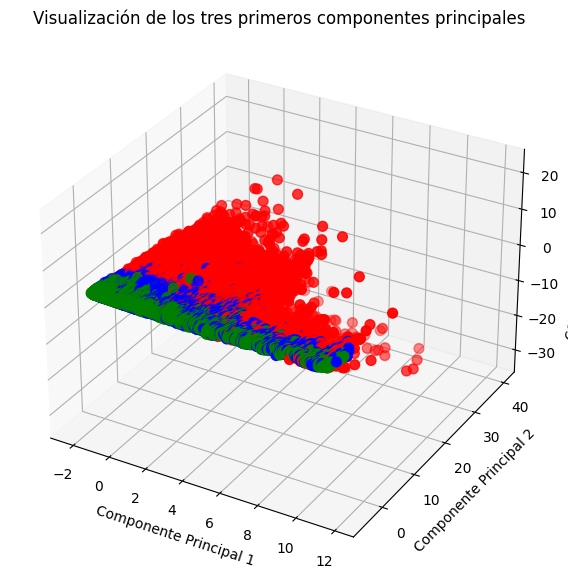

In [ ]:
# Graficar los tres primeros componentes principales, coloreados por la categoría de retraso
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Asignar colores según la categoría de retraso
colors = {'Early': 'green', 'Delay': 'red', 'On time': 'blue'}
ax.scatter(df_clean_pca['PC1'], df_clean_pca['PC2'], df_clean_pca['PC3'],
           c=df_clean_pca['ARR_DELAY_CATEGORY'].map(colors), s=50)

ax.set_title('Visualización de los tres primeros componentes principales')
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Componente Principal 3')

plt.show()


### **Selección de características.**

In [ ]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

df_clean = df.dropna()

# Seleccionar solo las variables originales
variables_originales = ['DEP_DELAY', 'TAXI_OUT', 'CRS_ELAPSED_TIME', 'DISTANCE',
                        'CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'CRS_ARR_TIME']

# Preparar las características (X) y la variable objetivo (y)
X = df_clean[variables_originales]  # Variables originales
y = df_clean['ARR_DELAY']  # Variable objetivo (en minutos)

# Convertir la variable objetivo en categorías
y_category = pd.cut(y, bins=[-np.inf, -15, 15, np.inf], labels=['Early', 'On time', 'Delay'])

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_category, test_size=0.3, random_state=42, stratify=y_category)

# Aplicar regresión logística para la clasificación
model = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=1000)
model.fit(X_train, y_train)

# Predecir y evaluar el modelo
y_pred = model.predict(X_test)

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=['Early', 'On time', 'Delay']))

# Evaluar el rendimiento del modelo utilizando F1-score macro
f1 = f1_score(y_test, y_pred, average='macro')
print(f'F1-score macro del modelo de clasificación: {f1}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Reporte de clasificación:
              precision    recall  f1-score   support

       Early       0.91      0.78      0.84    488085
     On time       0.62      0.35      0.45    543798
       Delay       0.77      0.91      0.83   1668117

    accuracy                           0.77   2700000
   macro avg       0.77      0.68      0.71   2700000
weighted avg       0.76      0.77      0.76   2700000

F1-score macro del modelo de clasificación: 0.7071729786275988


In [ ]:
# Obtener los coeficientes del modelo para cada clase
coef = model.coef_

# Mostrar los coeficientes
for i, clase in enumerate(['Early', 'On time', 'Delay']):
    print(f"\nCoeficientes para la clase '{clase}':")
    coef_clase = pd.Series(coef[i], index=variables_originales)
    print(coef_clase.sort_values(ascending=False))  # Ordenar los coeficientes de mayor a menor



Coeficientes para la clase 'Early':
DEP_DELAY           6.274278
DISTANCE            2.875846
TAXI_OUT            1.281326
WHEELS_OFF          0.095191
DEP_TIME            0.082082
CRS_ARR_TIME        0.033764
CRS_DEP_TIME       -0.250751
CRS_ELAPSED_TIME   -3.189369
dtype: float64

Coeficientes para la clase 'On time':
CRS_ELAPSED_TIME    3.861050
CRS_DEP_TIME        0.291060
CRS_ARR_TIME       -0.010427
DEP_TIME           -0.093056
WHEELS_OFF         -0.130949
TAXI_OUT           -1.266756
DISTANCE           -3.396278
DEP_DELAY          -6.564194
dtype: float64

Coeficientes para la clase 'Delay':
DISTANCE            0.511595
DEP_DELAY           0.281151
WHEELS_OFF          0.027114
DEP_TIME            0.003223
TAXI_OUT           -0.006424
CRS_ARR_TIME       -0.015073
CRS_DEP_TIME       -0.031514
CRS_ELAPSED_TIME   -0.662839
dtype: float64


In [ ]:
df_clean_pca.head()


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,CRS_ARR_TIME,ARR_DELAY,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY_CATEGORY,PC1,PC2,PC3
0,2009-09-05,AA,2062,MIA,BOS,10:55:00,11:39:00,44.0,15.0,1154.0,14:05:00,30.0,190.0,1258.0,Delay,1.080264,0.556730,-0.795043
1,2009-05-08,XE,2926,IAH,ELP,21:15:00,21:12:00,-3.0,17.0,2129.0,22:19:00,-15.0,124.0,667.0,Early,-0.257634,-0.136428,0.335183
2,2009-03-16,OH,6433,CVG,DSM,14:30:00,14:25:00,-5.0,25.0,1450.0,15:18:00,7.0,108.0,505.0,On time,-0.470948,0.415408,1.065250
3,2009-03-04,OO,5439,LAX,SBA,08:20:00,08:14:00,-6.0,15.0,829.0,09:05:00,-11.0,45.0,89.0,On time,-1.723492,-0.157711,0.353854
4,2009-06-12,WN,615,LAS,MCI,12:35:00,12:34:00,-1.0,13.0,1247.0,17:35:00,-26.0,180.0,1140.0,Early,0.766744,-0.507589,-0.132561


### **Evaluación 'interna' con al menos 10 algoritmos de inferencia**


k-Nearest Neighbors (kNN):
F1-score macro: 0.7152685690708022
              precision    recall  f1-score   support

       Delay       0.87      0.79      0.83    506848
       Early       0.54      0.48      0.51    543584
     On time       0.78      0.83      0.81   1647628

    accuracy                           0.76   2698060
   macro avg       0.73      0.70      0.72   2698060
weighted avg       0.75      0.76      0.75   2698060

F1-score macro: 0.7075371729750154
              precision    recall  f1-score   support

       Delay       0.88      0.77      0.83    506848
       Early       0.56      0.42      0.48    543584
     On time       0.77      0.86      0.81   1647628

    accuracy                           0.76   2698060
   macro avg       0.74      0.69      0.71   2698060
weighted avg       0.75      0.76      0.75   2698060

F1-score macro: 0.7148098398849795
              precision    recall  f1-score   support

       Delay       0.87      0.79      0.83    506

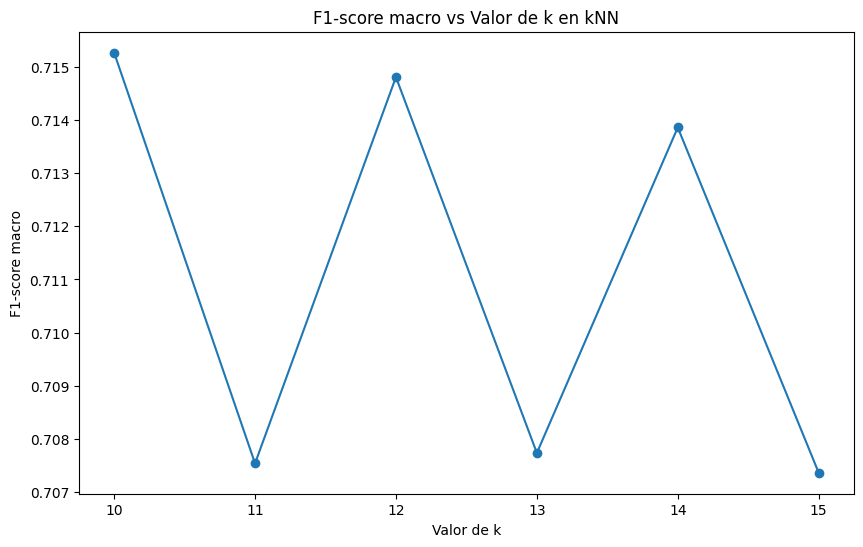

In [ ]:
# Definir una función para evaluar modelos con F1-score macro
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f'F1-score macro: {f1_macro}')
    print(classification_report(y_test, y_pred))
    return f1_macro

# 3. k-Nearest Neighbors (kNN) - Optimización del valor de k
print("\nk-Nearest Neighbors (kNN):")
k_values = range(10, 16)
f1_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    f1_macro = evaluate_model(knn, X_train, X_test, y_train, y_test)
    f1_scores.append(f1_macro)

# Graficar el F1-score macro contra los valores de k
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o')
plt.title('F1-score macro vs Valor de k en kNN')
plt.xlabel('Valor de k')
plt.ylabel('F1-score macro')
plt.show()

In [ ]:
# Importar las librerías necesarias
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

# Seleccionar solo los componentes principales como características
X = df_clean_pca[['PC1', 'PC2', 'PC3']]
y = df_clean_pca['ARR_DELAY_CATEGORY']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Definir una función para evaluar modelos con F1-score macro
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f'F1-score macro: {f1_macro}')
    print(classification_report(y_test, y_pred))
    return f1_macro

# 1. Regresión Logística
print("Regresión Logística:")
log_reg = LogisticRegression(max_iter=1000, random_state=42)
evaluate_model(log_reg, X_train, X_test, y_train, y_test)

# 2. Gradient Boosting
print("\nGradient Boosting:")
gbc = GradientBoostingClassifier(random_state=42)
evaluate_model(gbc, X_train, X_test, y_train, y_test)

# 3. Random Forest
print("\nRandom Forest:")
rf = RandomForestClassifier(random_state=42)
evaluate_model(rf, X_train, X_test, y_train, y_test)

# 4. Extra Trees Classifier
print("\nExtra Trees Classifier:")
et = ExtraTreesClassifier(random_state=42)
evaluate_model(et, X_train, X_test, y_train, y_test)

# 5. AdaBoost
print("\nAdaBoost:")
ada = AdaBoostClassifier(random_state=42)
evaluate_model(ada, X_train, X_test, y_train, y_test)

# 6. Bagging Classifier
print("\nBagging Classifier:")
bagging = BaggingClassifier(random_state=42)
evaluate_model(bagging, X_train, X_test, y_train, y_test)

#7. Máquinas de soporte vectorial (SVM)
print("\nMáquinas de soporte vectorial (SVM):")
svm = SVC(kernel='linear')  # Se puede ajustar a otros kernels como 'rbf' o 'poly'
evaluate_model(svm, X_train, X_test, y_train, y_test)



Regresión Logística:
F1-score macro: 0.6599295690710193
              precision    recall  f1-score   support

       Delay       0.90      0.77      0.83    506848
       Early       0.58      0.23      0.33    543584
     On time       0.74      0.92      0.82   1647628

    accuracy                           0.75   2698060
   macro avg       0.74      0.64      0.66   2698060
weighted avg       0.74      0.75      0.72   2698060


Gradient Boosting:
F1-score macro: 0.673813531701318
              precision    recall  f1-score   support

       Delay       0.90      0.77      0.83    506848
       Early       0.58      0.27      0.37    543584
     On time       0.75      0.91      0.82   1647628

    accuracy                           0.76   2698060
   macro avg       0.74      0.65      0.67   2698060
weighted avg       0.74      0.76      0.73   2698060


Random Forest:


Árbol de Decisión:
F1-score macro: 0.6768401761057593
              precision    recall  f1-score   support

       Delay       0.76      0.77      0.77    506848
       Early       0.48      0.50      0.49    543584
     On time       0.78      0.76      0.77   1647628

    accuracy                           0.71   2698060
   macro avg       0.67      0.68      0.68   2698060
weighted avg       0.71      0.71      0.71   2698060


Naive Bayes:
F1-score macro: 0.5595492881441718
              precision    recall  f1-score   support

       Delay       0.78      0.53      0.63    506848
       Early       0.43      0.21      0.28    543584
     On time       0.69      0.87      0.77   1647628

    accuracy                           0.67   2698060
   macro avg       0.63      0.54      0.56   2698060
weighted avg       0.65      0.67      0.64   2698060


k-Nearest Neighbors (kNN):
F1-score macro: 0.67038753232364
              precision    recall  f1-score   support

       Delay       

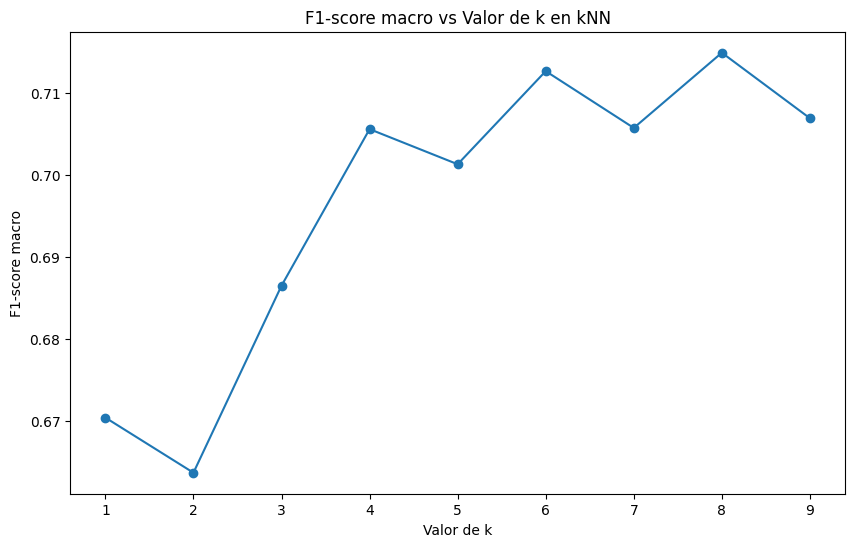

In [ ]:
# Importar las librerías necesarias
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Dividir los datos en características y etiquetas (ARR_DELAY_CATEGORY)
X = df_clean_pca[['PC1', 'PC2', 'PC3']]  # Usamos los 3 componentes principales
y = df_clean_pca['ARR_DELAY_CATEGORY']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Definir una función para evaluar modelos con F1-score macro
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f'F1-score macro: {f1_macro}')
    print(classification_report(y_test, y_pred))
    return f1_macro

# 1. Árbol de decisión (C4.5 es una mejora del ID3, y se usa comúnmente DecisionTreeClassifier)
print("Árbol de Decisión:")
decision_tree = DecisionTreeClassifier(random_state=42)
evaluate_model(decision_tree, X_train, X_test, y_train, y_test)

# 2. Naive Bayes (Aprendizaje Bayesiano)
print("\nNaive Bayes:")
naive_bayes = GaussianNB()
evaluate_model(naive_bayes, X_train, X_test, y_train, y_test)

# 3. k-Nearest Neighbors (kNN) - Optimización del valor de k
print("\nk-Nearest Neighbors (kNN):")
k_values = range(1, 21)
f1_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    f1_macro = evaluate_model(knn, X_train, X_test, y_train, y_test)
    f1_scores.append(f1_macro)

# Graficar el F1-score macro contra los valores de k
plt.figure(figsize=(10, 6))
plt.plot(k_values, f1_scores, marker='o')
plt.title('F1-score macro vs Valor de k en kNN')
plt.xlabel('Valor de k')
plt.ylabel('F1-score macro')
plt.show()



# Selección del mejor modelo

In [17]:
# Importar las librerías necesarias
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

# Importar las librerías necesarias
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Seleccionar solo los componentes principales como características
X = df_clean_pca[['PC1', 'PC2', 'PC3']]
y = df_clean_pca['ARR_DELAY_CATEGORY']

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Definir una función para evaluar modelos con F1-score macro
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    print(f'F1-score macro: {f1_macro}')
    print(classification_report(y_test, y_pred))
    return f1_macro

# 3. k-Nearest Neighbors (kNN) - Optimización del valor de k
print("\nk-Nearest Neighbors (kNN):")

knn = KNeighborsClassifier(n_neighbors=10)
f1_macro = evaluate_model(knn, X_train, X_test, y_train, y_test)



k-Nearest Neighbors (kNN):
F1-score macro: 0.715364828652152
              precision    recall  f1-score   support

       Delay       0.87      0.79      0.83    507842
       Early       0.54      0.48      0.51    543798
     On time       0.78      0.83      0.81   1648360

    accuracy                           0.76   2700000
   macro avg       0.73      0.70      0.72   2700000
weighted avg       0.75      0.76      0.75   2700000



# Predicción del mejor modelo

In [19]:
# Cargar los datos
df1 = pd.read_csv('drive/MyDrive/test_airlines_delay_challenge.csv')

# Mostrar las primeras filas del dataset
df1.head()

# Información general sobre el dataset
df1.info()

# Descripción estadística del dataset
df1.describe()

# Revisión de valores nulos
print(df1.isnull().sum())

# Limpieza de datos

# Eliminar filas con valores nulos (si es necesario)
df1_clean = df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2250000 entries, 0 to 2249999
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FL_DATE            object 
 1   OP_CARRIER         object 
 2   OP_CARRIER_FL_NUM  int64  
 3   ORIGIN             object 
 4   DEST               object 
 5   CRS_DEP_TIME       int64  
 6   DEP_TIME           float64
 7   DEP_DELAY          float64
 8   TAXI_OUT           float64
 9   WHEELS_OFF         float64
 10  CRS_ARR_TIME       int64  
 11  CRS_ELAPSED_TIME   float64
 12  DISTANCE           float64
dtypes: float64(6), int64(3), object(4)
memory usage: 223.2+ MB
FL_DATE              0
OP_CARRIER           0
OP_CARRIER_FL_NUM    0
ORIGIN               0
DEST                 0
CRS_DEP_TIME         0
DEP_TIME             0
DEP_DELAY            0
TAXI_OUT             0
WHEELS_OFF           0
CRS_ARR_TIME         0
CRS_ELAPSED_TIME     0
DISTANCE             0
dtype: int64


In [21]:

# Importar las librerías necesarias
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Seleccionar solo las variables numéricas
df1_numeric = df1[['DEP_DELAY', 'TAXI_OUT', 'CRS_ELAPSED_TIME', 'DISTANCE']]

# Estandarizar los datos (media = 0 y varianza = 1)
scaler = StandardScaler()
df1_scaled = scaler.fit_transform(df1_numeric)

# Aplicar PCA con tres componentes principales
pca = PCA(n_components=3)
pca_components = pca.fit_transform(df1_scaled)

# Crear un nuevo DataFrame con los tres componentes principales
df1_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2', 'PC3'])


# 1. Seleccionar los componentes principales del nuevo conjunto de datos
X_new = df1_pca[['PC1', 'PC2', 'PC3']]

# 2. Usar el modelo kNN entrenado para hacer predicciones
y_new_pred = knn.predict(X_new)

# 3. Agregar las predicciones al dataframe original de los nuevos datos
df1['ARR_DELAY_CATEGORY_PRED'] = y_new_pred

# 4. Guardar el dataframe con las predicciones en un archivo CSV
df1.to_csv('predicciones_vuelos.csv', index=False)

# Mostrar mensaje de éxito
print("Predicciones guardadas en el archivo 'predicciones_vuelos.csv'")


Predicciones guardadas en el archivo 'predicciones_vuelos.csv'


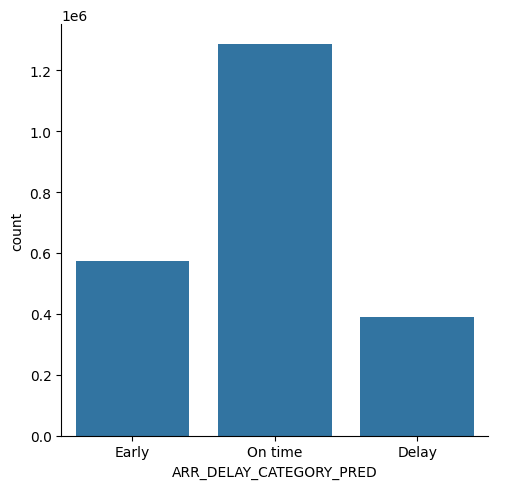

In [24]:
df2 = pd.read_csv('predicciones_vuelos.csv')

# Mostrar las primeras filas del dataset
df2.head()


sns.catplot(data=df2, x="ARR_DELAY_CATEGORY_PRED", kind="count")